In [ ]:
import os
import gdown
import zipfile
from tqdm import tqdm
import cv2
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.preprocessing import image

In [ ]:
# Fungsi untuk mengunduh file dari Google Drive
def download_file_from_google_drive(file_url, destination):
    gdown.download(file_url, destination, quiet=False)

# Definisi link Google Drive dataset
file_url = 'https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF'
destination = '/content/Dataset.zip'

# Unduh dataset dari Google Drive
download_file_from_google_drive(file_url, destination)

# Ekstrak file zip dataset
extract_path = '/content/Dataset'
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset telah diunduh dan diekstrak.")

Downloading...
From (original): https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF
From (redirected): https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF&confirm=t&uuid=0856f724-aad2-466d-933f-6f2953b8e0d6
To: /content/Dataset.zip
100%|██████████| 223M/223M [00:01<00:00, 186MB/s]


Dataset telah diunduh dan diekstrak.


In [ ]:
# Definisikan path untuk train dan test
train_path = '/content/Dataset/Dataset/Train'
test_path = '/content/Dataset/Dataset/Test'

x_data = []
y_data = []

# Loop melalui setiap kategori (Recyclable dan Organic)
for category in glob(train_path + '/*'):
    # Ambil nama kategori dari path
    category_name = os.path.basename(category)
    print("Exploring category:", category_name)

    # Loop melalui setiap file dalam kategori
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Simpan gambar dan label ke dalam list
        x_data.append(img_array)
        y_data.append(category_name)

# Buat DataFrame dari data yang telah diambil
data = pd.DataFrame({'image': x_data, 'label': y_data})

Exploring category: Organic


100%|██████████| 12565/12565 [00:13<00:00, 902.83it/s]


Exploring category: Recyclable


100%|██████████| 9999/9999 [00:09<00:00, 1061.45it/s]


In [ ]:
print(data.shape)

(22564, 2)


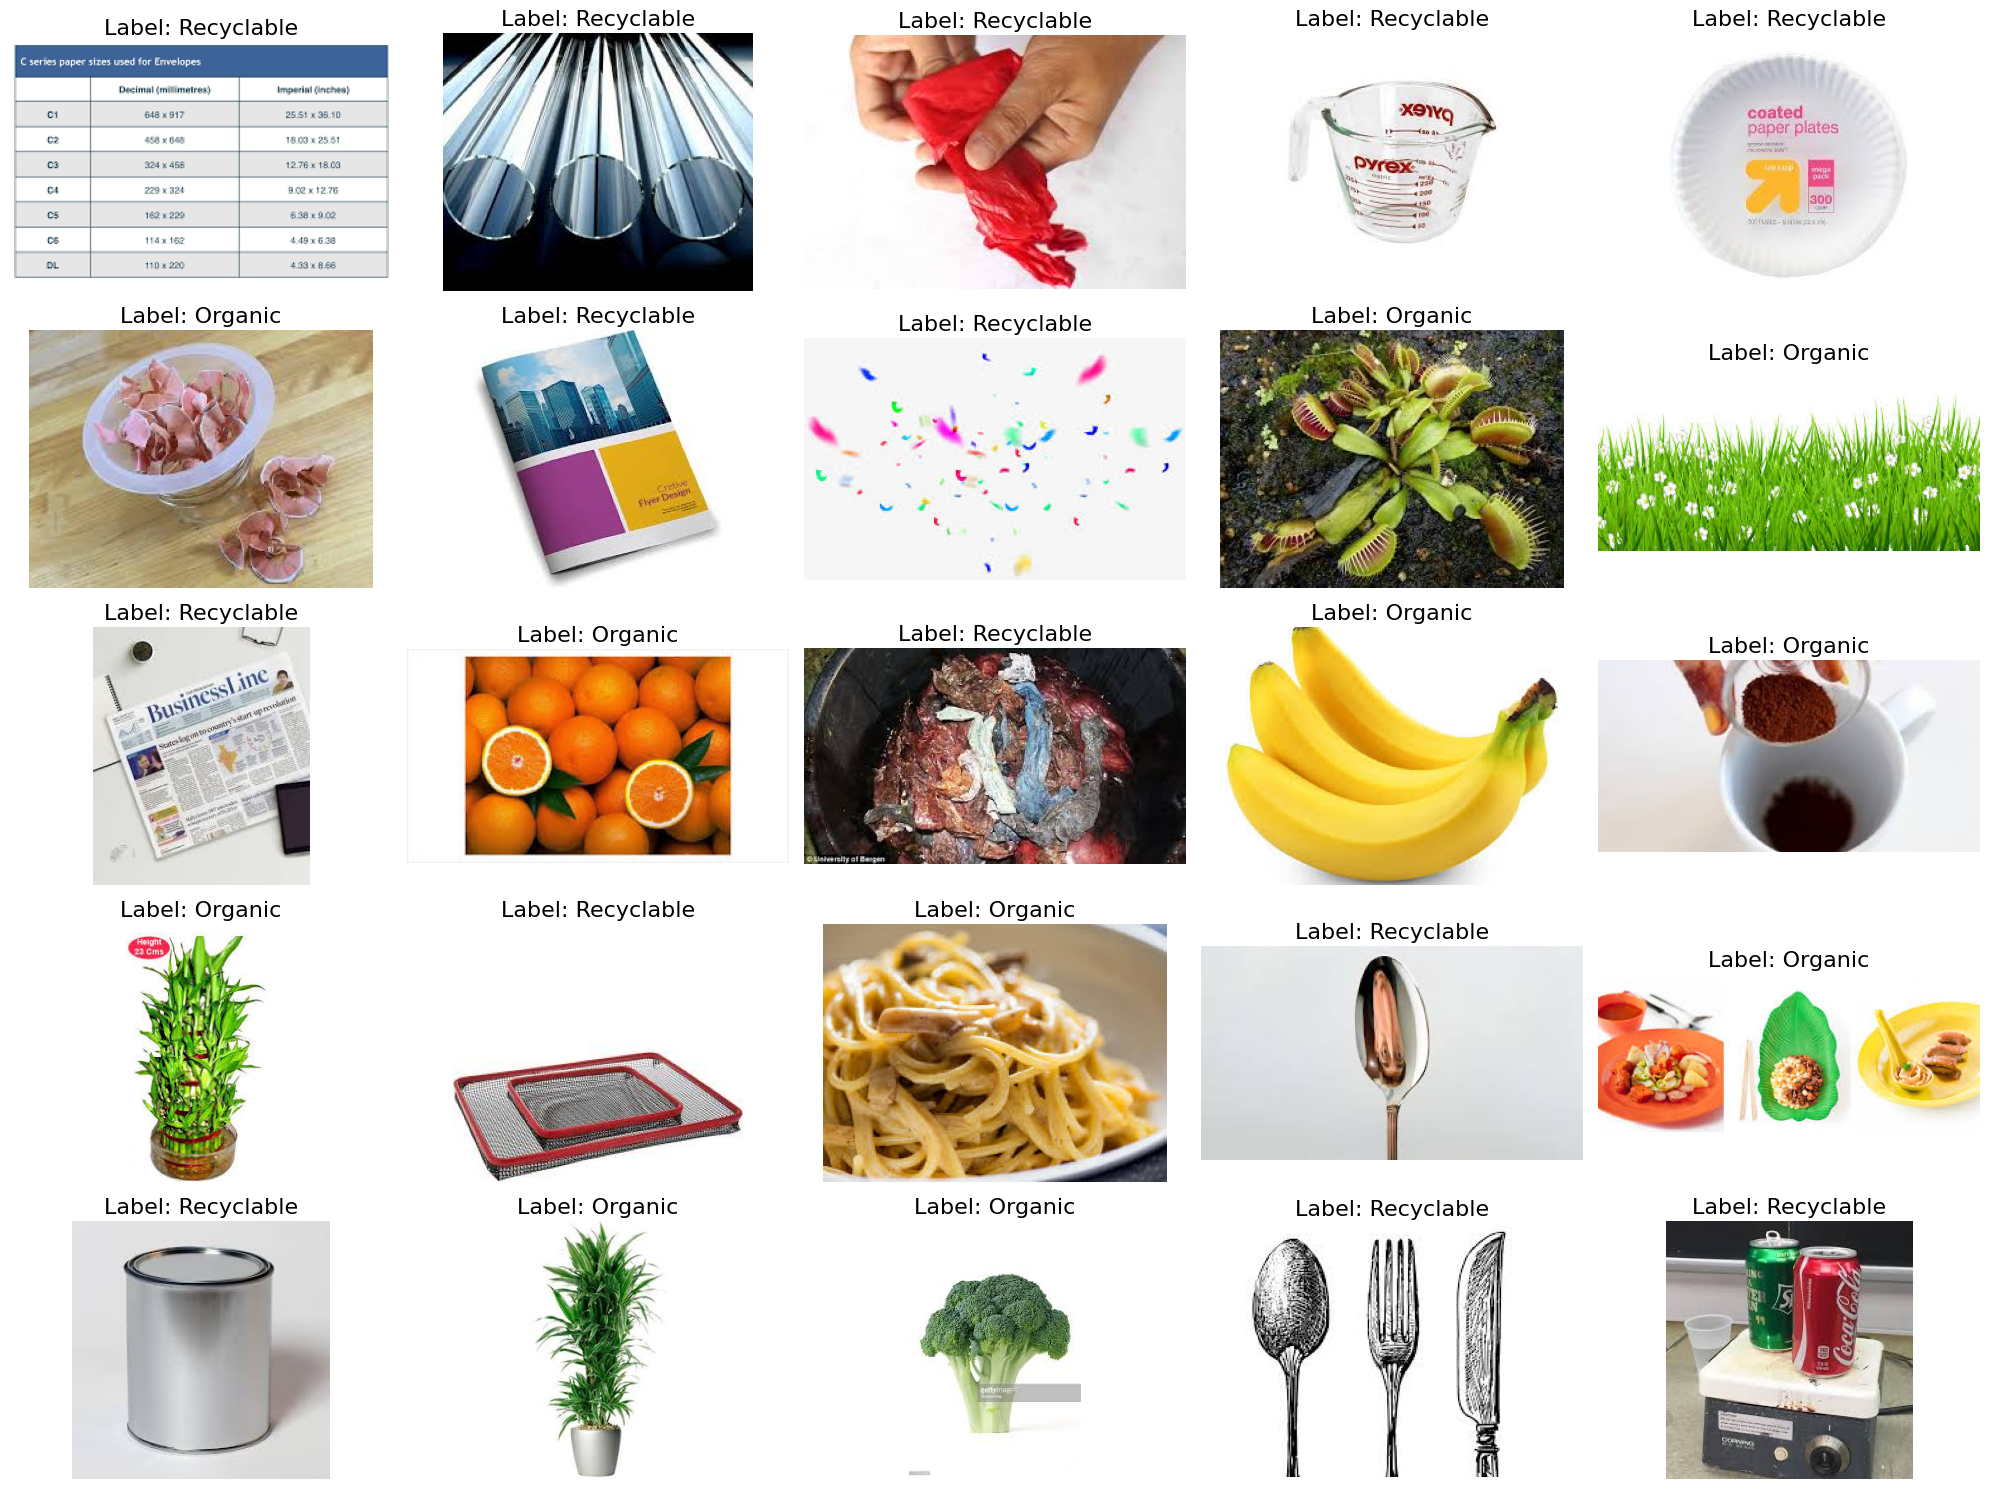

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    index = np.random.randint(len(data))
    plt.title('Label: {}'.format(data.label[index]), fontsize=16)
    plt.imshow(data.image[index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85:
            print("\nUdah lah, cukup, kasihanilah laptop saya !!!")
            self.model.stop_training = True

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(numberOfClass, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)
batch_size = 256

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[myCallback()]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 2561s 29s/step - accuracy: 0.7110 - loss: 0.7102 - val_accuracy: 0.8687 - val_loss: 0.3713
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2574s 29s/step - accuracy: 0.8277 - loss: 0.4229 - val_accuracy: 0.8866 - val_loss: 0.3121
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2635s 30s/step - accuracy: 0.8475 - loss: 0.3771 - val_accuracy: 0.8798 - val_loss: 0.3112
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8590 - loss: 0.3483 
Udah lah, cukup, kasihanilah laptop saya !!!
89/89 ━━━━━━━━━━━━━━━━━━━━ 2636s 30s/step - accuracy: 0.8590 - loss: 0.3483 - val_accuracy: 0.8758 - val_loss: 0.3233


In [15]:
model.save('/content/saved_model.h5')

In [23]:
import tensorflowjs as tfjs

# Konversi model Keras ke format TensorFlow.js
tfjs.converters.save_keras_model(model, '/content/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [38]:
import shutil
# Arsipkan direktori model tfjs
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

# Unduh arsip model tfjs
files.download('/content/tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving O_13593.jpg to O_13593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


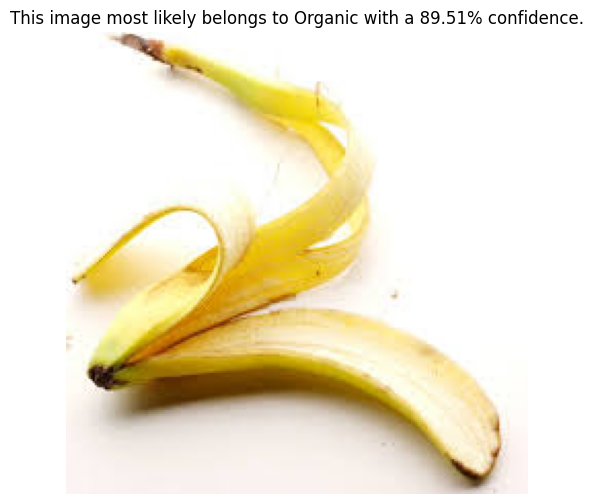

In [48]:
def upload_and_predict_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)

        class_names = list(train_generator.class_indices.keys())  # Mengambil nama kelas dari generator

        predicted_class = class_names[np.argmax(prediction)]
        confidence = 100 * np.max(prediction)

        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(path))
        plt.title(f'This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.')
        plt.axis('off')
        plt.show()

# Panggil fungsi upload dan prediksi
upload_and_predict_image()
